In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
from scipy.ndimage import uniform_filter
from scipy import interpolate
from matplotlib import cm

In [2]:
consts = {
    'f0'   : 10**-4,
    'beta' : 10**-11,
    'g'    : 10,
    'gamma': 10**-6,
    'rho'  : 1000,
    'H'    : 1000,
    'L'    : 10**6,
    'tau_0': 0.2,
}

epsilon = consts['gamma']/(consts['L']*consts['beta'])
a = (-1 - np.sqrt(1 + (2*np.pi*epsilon)**2)) / (2*epsilon)
b = (-1 + np.sqrt(1 + (2*np.pi*epsilon)**2)) / (2*epsilon)

consts['epsilon'] = epsilon
consts['a'] = a
consts['b'] = b

In [3]:
def steady_state_sol(dx, dy, eta_0, consts=consts):
    tau_0 = consts['tau_0']
    rho = consts['rho']
    H = consts['H']
    L = consts['L']
    gamma = consts['gamma']
    g = consts['g']
    f0 = consts['f0']
    beta = consts['beta']
    
    coeff = tau_0/(np.pi*gamma*rho*H)
    
    x = np.arange(0, consts['L'], dx)
    y = np.arange(0, consts['L'], dx) 
    nx = int(consts['L']/dx)
    ny = int(consts['L']/dy)
    
    X, Y = np.meshgrid(x, y) 

    u_st = -coeff*np.multiply(f1(X/L),np.cos(np.pi*Y/L))
    v_st = coeff*np.multiply(f2(X/L),np.sin(np.pi*Y/L))
    eta_st = coeff*f0*L/g*eta_term(X, Y)

    return [X, Y, u_st, v_st, eta_st]

def f1(X, consts=consts):
    a = consts['a']
    b = consts['b']

    c = ((np.exp(a)-1)*np.exp(b*X) + (1-np.exp(b))*np.exp(a*X))/(np.exp(b) - np.exp(a))
    f = np.pi*(1 + c)
    return f

def f2(X, consts=consts):
    a = consts['a']
    b = consts['b']

    f = ((np.exp(a)-1)*b*np.exp(b*X) + (1 - np.exp(b))*a*np.exp(a*X))/(np.exp(b) - np.exp(a))
    return f

def eta_term(X, Y, consts=consts):
    tau_0 = consts['tau_0']
    rho = consts['rho']
    H = consts['H']
    L = consts['L']
    gamma = consts['gamma']
    g = consts['g']
    f0 = consts['f0']
    beta = consts['beta']

    f2_xy = gamma/(f0*np.pi)*np.multiply(f2(X/L),np.cos(np.pi*Y/L))
    f1_y = np.multiply(np.sin(np.pi*Y/L),(1+beta*Y/f0))+beta*L/(f0*np.pi)*np.cos(np.pi*Y/L)
    f1_xy = 1./np.pi*np.multiply(f1(X/L),f1_y)
    f= f2_xy+f1_xy
    
    return f

In [4]:
def run_model(dx, dy, dt, nt, consts=consts, output_energy=False):
  
  L = consts['L']
  nx = int(L/dx)
  ny = int(L/dy)

  X_u, Y_u, X_v, Y_v = Arakawa_C_grid(dx, dy)
  eta, u, v = init_arakawa_C(nx, ny)
  tau_x_u = Caculate_tau_x(Y_u)
  tau_y_v = np.zeros_like(X_v)
  energy = []

  # iteration order
  u_before_v_flag = True
  

  for t in range(nt):
    eta_new = iterate_eta(eta, u, v, dx, dy, dt)

    if u_before_v_flag:
      # iterate u first
      u_new = iterate_u(u, v, eta_new, Y_u, tau_x_u, dx, dt)
      v_new = iterate_v(u_new, v, eta_new, Y_v, tau_y_v, dy, dt)
    else:
      # Iterate v first
      v_new = iterate_v(u, v, eta_new, Y_v, tau_y_v, dy, dt)
      u_new = iterate_u(u, v_new, eta_new, Y_u, tau_x_u, dx, dt)
        
    energy.append(Perturbation_energy(u_new, v_new, eta_new, dx, dy))

    eta = eta_new.copy()
    u = u_new.copy()
    v = v_new.copy()
    u_before_v_flag = not u_before_v_flag
   
  return [u, v, eta, energy]

# create arakawa c grids 
def Arakawa_C_grid(dx, dy, consts=consts, Caculate_or_plot='Calculate'):
    # Create arrays of size l
    x = np.arange(0, consts['L'], dx)
    y = np.arange(0, consts['L'], dy)
    # Add dx,dy for the l+1 arrays which need an extra gridpoint
    x_plus_one = np.arange(0, consts['L']+dx, dx)
    y_plus_one = np.arange(0, consts['L']+dy, dy)

    # Shift gridpoints by a factor 0.5 * dx_dy for interpolated grids 
    x_v = x + 0.5*dx
    y_u = y + 0.5*dy

    # Create meshgrids for the u and v
    # u grid needs one extra point in x, interpolated values in y
    # v grid needs one extra point in y, interpolated values in x
    X_u, Y_u = np.meshgrid(x_plus_one, y_u)
    X_v, Y_v = np.meshgrid(x_v, y_plus_one)

    if Caculate_or_plot == 'Calculate':
        return [X_u, Y_u, X_v, Y_v]
    elif Caculate_or_plot == 'plot':
        return [x, y, x_plus_one, y_plus_one]
    else:
        return None
    
def init_arakawa_C(nx, ny):
    # For the Arakawa C grid, the dimensions for the data are:
    # eta: [ny  , nx  ]
    # u  : [ny  , nx+1]
    # v  : [ny+1, nx  ]

    eta_array = np.zeros((ny, nx))
    u_array = np.zeros((ny, nx+1))
    v_array = np.zeros((ny+1, nx))

    return[eta_array, u_array, v_array]

# Functions to precalculate tau matrices
def Caculate_tau_x(Y, consts=consts):
    tau_0 = consts['tau_0']
    L = consts['L']
    tau_x = -tau_0 * np.cos(np.pi*Y/L)
    # Now apply BCs
    tau_x[:,0] = 0
    tau_x[:,-1] = 0
    return tau_x

# Iterating functions
def iterate_eta(eta, u, v, dx, dy, dt, consts=consts):
    H = consts['H']
    dudx = np.diff(u, axis=1)/dx
    dvdy = np.diff(v, axis=0)/dy
    eta_new = eta - H*dt*(dudx + dvdy)
    return eta_new

def iterate_u(u, v, eta, Y, tau_x, dx, dt, consts=consts):
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    gamma = consts['gamma']
    f0 = consts['f0']
    beta = consts['beta']

    # Use filter function to get the average of four neighbouring v values on u grid
    v_filtered = uniform_filter(v, size=2, mode='constant', cval=0, origin=(-1,0))
    v_filtered = v_filtered[:-1,:]
    v_filtered[:,0] = 0
    v_filtered = np.pad(v_filtered, pad_width=((0,0),(0,1)))

    d_eta_dx = np.diff(eta, axis=1)/dx
    d_eta_dx = np.pad(d_eta_dx, pad_width=((0,0),(1,1)))

    corli = (f0 + beta*Y) * dt * v_filtered   # coriolis term
    eta_grid = -d_eta_dx * g * dt                      # eta grad term
    tau_x_term = tau_x*dt/(rho*H)                   # tau term 
    gamma_term = u * (1 - gamma*dt)                 # u and gamma terms
    return corli+eta_grid+tau_x_term+gamma_term

def iterate_v(u, v, eta, Y, tau_y, dy, dt, consts=consts):
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    gamma = consts['gamma']
    f0 = consts['f0']
    beta = consts['beta']

    # Use filter function to get the average of four neighbouring u values on v grid
    u_filtered = uniform_filter(u, size=2, mode='constant', cval=0, origin=(0,-1))
    u_filtered = u_filtered[:,:-1]
    u_filtered[0,:] = 0
    u_filtered = np.pad(u_filtered, pad_width=((0,1),(0,0)))

    d_eta_dy = np.diff(eta, axis=0)/dy
    d_eta_dy = np.pad(d_eta_dy, pad_width=((1,1),(0,0)))

    corli = -(f0 + beta*Y) * dt * u_filtered   # coriolis term
    eta_grid = -d_eta_dy * g * dt                       # eta grad term
    tau_y_term = tau_y*dt/(rho*H)                    # tau term
    gamma_term = v * (1 - gamma*dt)                  # v and gamma terms
    return corli+eta_grid+tau_y_term+gamma_term

# Other Functions
def reshape_arrays_to_equal_size(u_array, v_array):

    pad_array = np.zeros(len(u_array[0]))
    u_array = np.vstack([u_array, pad_array])
    v_array = np.pad(v_array, (0,1))[:-1,:]
    # eta_array = np.pad(eta_array, (0,1))
    return [u_array, v_array]

def Perturbation_energy(u, v, eta, dx, dy, consts=consts):
    rho = consts['rho']
    H = consts['H']
    g = consts['g']
    # First, reshape u and v arrays to be of equal size:
    u, v = reshape_arrays_to_equal_size(u, v)

    # Now, reshape eta array to be of same size as above
    # TODO: make a function for this?
    eta = np.pad(eta, (0,1))

    wind_speed = u**2 + v**2
    energy_per_gridpoint = 0.5*rho*dx*dy * (H*wind_speed + g*eta**2)
    total_energy = np.sum(energy_per_gridpoint)
    return total_energy

def plot_energy(plt_id, energy, dt, nt, dx):

    # Create time array, in days
    t = np.arange(0, dt*nt, dt)
    t = t/(60*60*24)
    
    fig = plt.figure(plt_id)
    plt11 = plt.plot(t, energy, label='Perturbation energy')
    plt.xlabel("Time (days)")
    plt.ylabel("Perturbation Energy (J)")
    plt.title('Energy with time') 
        
def plot_Task_D1(dy, x, y, x_plus_one, y_plus_one, u, v, eta, \
                plt_id = 0, y_lim = [-0.1,0.1], legend_loc= 'upper right'): 
    
    u, v = reshape_arrays_to_equal_size(u, v)
    
    L = consts['L']
    X_uv, Y_uv = np.meshgrid(x_plus_one, y_plus_one)
    
    fig2 = plt.figure(plt_id)
    plt2 = plt.contourf(X_uv, Y_uv, u, cmap=cm.coolwarm)
    cbar1 = fig2.colorbar(plt2, label='u (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('u -Numerical solution (1 Day)')
    
    fig3 = plt.figure(plt_id+1)
    plt3 = plt.contourf(X_uv, Y_uv, v, cmap=cm.coolwarm)
    cbar2 = fig3.colorbar(plt3, label='v (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('v -Numerical solution (1 Day)')
    
    X_eta, Y_eta = np.meshgrid(x, y)
    fig4 = plt.figure(plt_id+2)
    plt4 = plt.contourf(X_eta, Y_eta, eta, cmap=cm.coolwarm)
    cbar4 = fig4.colorbar(plt4, label='Height (m)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('$\eta$ -Numerical solution (1 Day)')
    
    fig5 = plt.figure(plt_id+3)
    plt4 = plt.plot(x_plus_one, u[0,:],'b',label='u along south boundary')
    plt4 = plt.plot(x_plus_one, v[:,0],'r',label='v along west boundary')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel("wind (ms$^{-1}$)")
    plt.title('Numerical solution (1 Day)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
    fig5 = plt.figure(plt_id+4)
    ny_half = int(consts['L']/(2*dy))
    plt5 = plt.plot(x, eta[ny_half,:],'g',label='$\eta$ through the middle of gyre')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel('Height (m)')
    plt.title('Numerical solution (1 Day)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
def plot_Task_D30(dy, x, y, x_plus_one, y_plus_one, u, v, eta, \
                plt_id = 0, y_lim = [-0.1,0.1], legend_loc= 'upper right'): 
    
    u, v = reshape_arrays_to_equal_size(u, v)
    
    L = consts['L']
    X_uv, Y_uv = np.meshgrid(x_plus_one, y_plus_one)
    
    fig2 = plt.figure(plt_id)
    plt2 = plt.contourf(X_uv, Y_uv, u, cmap=cm.coolwarm)
    cbar1 = fig2.colorbar(plt2, label='u (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('u -Numerical solution (30 Days)')
    
    fig3 = plt.figure(plt_id+1)
    plt3 = plt.contourf(X_uv, Y_uv, v, cmap=cm.coolwarm)
    cbar2 = fig3.colorbar(plt3, label='v (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('v -Numerical solution (30 Days)')
    
    X_eta, Y_eta = np.meshgrid(x, y)
    fig4 = plt.figure(plt_id+2)
    plt4 = plt.contourf(X_eta, Y_eta, eta, cmap=cm.coolwarm)
    cbar4 = fig4.colorbar(plt4, label='Height (m)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('$\eta$ -Numerical solution (30 Days)')
    
    fig5 = plt.figure(plt_id+3)
    plt4 = plt.plot(x_plus_one, u[0,:],'b',label='u along south boundary')
    plt4 = plt.plot(x_plus_one, v[:,0],'r',label='v along west boundary')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel("wind (ms$^{-1}$)")
    plt.title('Numerical solution (30 Days)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
    fig5 = plt.figure(plt_id+4)
    ny_half = int(consts['L']/(2*dy))
    plt5 = plt.plot(x, eta[ny_half,:],'g',label='$\eta$ through the middle of gyre')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel('Height (m)')
    plt.title('Numerical solution (30 Days)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
    
def plot_Task_Ddiff(dy, x, y, x_plus_one, y_plus_one, u, v, eta, \
                plt_id = 0, y_lim = [-0.1,0.1], legend_loc= 'upper right'): 
    
    u, v = reshape_arrays_to_equal_size(u, v)
    
    L = consts['L']
    X_uv, Y_uv = np.meshgrid(x_plus_one, y_plus_one)
    
    fig2 = plt.figure(plt_id)
    plt2 = plt.contourf(X_uv, Y_uv, u, cmap=cm.coolwarm)
    cbar1 = fig2.colorbar(plt2, label='u (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('The difference of u')
    
    fig3 = plt.figure(plt_id+1)
    plt3 = plt.contourf(X_uv, Y_uv, v, cmap=cm.coolwarm)
    cbar2 = fig3.colorbar(plt3, label='v (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('The difference of v')
    
    X_eta, Y_eta = np.meshgrid(x, y)
    fig4 = plt.figure(plt_id+2)
    plt4 = plt.contourf(X_eta, Y_eta, eta, cmap=cm.coolwarm)
    cbar4 = fig4.colorbar(plt4, label='Height (m)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('The difference of $\eta$')

In [5]:
# parameter setup
L, f_0, beta, g, gamma, rho, H, tau_0 = consts['L'], consts['f0'], consts['beta'], \
       consts['g'], consts['gamma'], consts['rho'], consts['H'], consts['tau_0']     
epsilon = gamma/(L*beta)                   
  
def interpolate2D(para, xarray, yarray, xdepmesh, ydepmesh):
    para_int = interpolate.RegularGridInterpolator\
        ((yarray, xarray), values=para, method = 'linear', \
         bounds_error = False, fill_value = None)

    intpara_array = para_int((ydepmesh, xdepmesh))

    return intpara_array


def deptpoint(X_ets, Y_ets, eta_u_arr, eta_v_arr, dt):
    x_dept = X_ets - eta_u_arr * dt
    y_dept = Y_ets - eta_v_arr * dt
    
    return x_dept, y_dept    

def semi_lagrangian(dx, dy, dt, nt):
    nx = int(L/dx)
    ny = int(L/dy)
    """Loop Semi-Lagrangian scheme over time"""
    
    x, y, x_u, y_v = Arakawa_C_grid(dx, dy, consts, 'plot')
    x_v = x + 0.5*dx
    y_u = y + 0.5*dy
    x_eta = x + 0.5*dx
    y_eta = y + 0.5*dy
    
    X_u, Y_u = np.meshgrid(x_u, y_u)
    X_v, Y_v = np.meshgrid(x_v, y_v)
    X_ets, Y_ets = np.meshgrid(x_eta, y_eta)

    eta, u, v = init_arakawa_C(nx, ny)

    t = dt*nt
    energy = [] 

    for it in range(nt): 
        
       # The boundary condition
       u[:,0] = 0
       u[:,-1] = 0
       v[0,:] = 0
       v[-1,:] = 0
        
        
       eta_u = interpolate2D(u, x_u, y_u, X_ets, Y_ets)
       eta_v = interpolate2D(v, x_v, y_v, X_ets, Y_ets)
       etaxdept, etaydept = deptpoint(X_ets, Y_ets, eta_u, eta_v, dt)
       etadept = interpolate2D(eta, x_eta, y_eta, etaxdept, etaydept)
   
       # dudx and dvdy        
       dudx = np.diff(u, axis=1)/dx
       dudx_dept = interpolate2D(dudx, x_eta, y_eta, etaxdept, etaydept)
       dvdy = np.diff(v, axis=0)/dy
       dvdy_dept = interpolate2D(dvdy, x_eta, y_eta, etaxdept, etaydept)

       # Source term on grid point and departure point
       H_div_grid = -H * (dudx + dvdy)*dt
       H_div_dept = -H * (dudx_dept + dvdy_dept)*dt

        
       #  Lagrangian eta
       eta_new = etadept + 0.5 * (H_div_grid + H_div_dept)
      
       detadx = np.diff(eta_new, axis=1)/dx
       detadx = np.pad(detadx, [(0,0),(1,1)], mode='constant')
       detady = np.diff(eta_new, axis=0)/dy
       detady = np.pad(detady, [(1,1),(0,0)], mode='constant')
       
       if it%2 == 1:
          #print(it)
          # u grid

          u_v = interpolate2D(v, x_v, y_v, X_u, Y_u)

          X_u_dept, Y_u_dept = deptpoint(X_u, Y_u, u, u_v, dt)
          u_dept = interpolate2D(u, x_u, y_u, X_u_dept, Y_u_dept)
          v_dept = interpolate2D(v, x_v, y_v, X_u_dept, Y_u_dept)
          tau_x = tau_0*(-np.cos(np.pi*Y_u/L))
          tau_x_dept = tau_0*(-np.cos(np.pi*Y_u_dept/L))
          u_source_grid = ((f_0 + beta*Y_u)*u_v - g*detadx \
                           - gamma*u + tau_x/(rho*H)) * dt

          detadx_dept = interpolate2D(detadx, x_u, y_u, X_u_dept, Y_u_dept)
          u_source_dept = ((f_0 + beta*Y_u_dept)*v_dept \
                           - g*detadx_dept - gamma*u_dept + tau_x_dept/(rho*H)) * dt

          # Lagrangian u
          u = u_dept + 0.5 * (u_source_grid + u_source_dept)
  
          # v grid

          v_u = interpolate2D(u, x_u, y_u, X_v, Y_v)

          X_v_dept, Y_v_dept = deptpoint(X_v, Y_v, v_u, v, dt)
          v_source_grid = (-(f_0 + beta*Y_v)*v_u - g*detady - gamma*v ) * dt 
          u_dept = interpolate2D(u, x_u, y_u, X_v_dept, Y_v_dept)
          detady_dept = interpolate2D(detady, x_v, y_v, X_v_dept, Y_v_dept)
          v_dept = interpolate2D(v, x_v, y_v, X_v_dept, Y_v_dept)  
          v_source_dept = (-(f_0 + beta*Y_v_dept)*u_dept \
                           - g*detady_dept - gamma*v_dept) * dt  
 
          # Lagrangian v
          v = v_dept + 0.5 * (v_source_grid + v_source_dept)
          
       else :
          
          # v grid
          # Calculation of detady
          v_u = interpolate2D(u, x_u, y_u, X_v, Y_v)

          X_v_dept, Y_v_dept = deptpoint(X_v, Y_v, v_u, v, dt)
          v_source_grid = (-(f_0 + beta*Y_v)*v_u - g*detady - gamma*v)*dt 
          u_dept = interpolate2D(u, x_u, y_u, X_v_dept, Y_v_dept)
          detady_dept = interpolate2D(detady, x_v, y_v, X_v_dept, Y_v_dept)
          v_dept = interpolate2D(v, x_v, y_v, X_v_dept, Y_v_dept)  
          v_source_dept = (-(f_0 + beta*Y_v_dept)*u_dept \
                           - g*detady_dept - gamma*v_dept)*dt 

          # Lagrangian v
          v = v_dept + 0.5 *  (v_source_grid + v_source_dept)

          # u grid
          u_v = interpolate2D(v, x_v, y_v, X_u, Y_u)

          X_u_dept, Y_u_dept = deptpoint(X_u, Y_u, u, u_v, dt)
          u_dept = interpolate2D(u, x_u, y_u, X_u_dept, Y_u_dept)
          v_dept = interpolate2D(v, x_v, y_v, X_u_dept, Y_u_dept)

          tau_x = tau_0*(-np.cos(np.pi*Y_u/L))
          tau_x_dept = tau_0*(-np.cos(np.pi*Y_u_dept/L))

          u_source_grid = ((f_0 + beta*Y_u)*u_v - g*detadx \
                           - gamma*u + tau_x/(rho*H))* dt

          detadx_dept = interpolate2D(detadx, x_u, y_u, X_u_dept, Y_u_dept)
          u_source_dept = ((f_0 + beta*Y_u_dept)*v_dept \
                           - g*detadx_dept - gamma*u_dept + tau_x_dept/(rho*H))* dt

          # Lagrangian u
          u = u_dept + 0.5  * (u_source_grid + u_source_dept)
          
       eta = eta_new
       energy.append(Perturbation_energy(u, v, eta, dx, dy))
        

    return u, v, eta, energy


def plot_TaskF1(plt_id, u, v, eta, dx , dy, dt, nt, \
               y_lim = [-0.1,0.1], legend_loc= 'upper right'):
    
    x, y, x_u, y_v = Arakawa_C_grid(dx, dy, consts, 'plot')
    x_v = x + 0.5*dx
    y_u = y + 0.5*dy
    x_eta = x + 0.5*dx
    y_eta = y + 0.5*dy
    
    X_u, Y_u = np.meshgrid(x_u, y_u)
    X_v, Y_v = np.meshgrid(x_v, y_v)
    X_eta, Y_eta = np.meshgrid(x_eta, y_eta)
    
    fig2 = plt.figure(plt_id)
    plt2 = plt.contourf(X_u, Y_u, u, cmap=cm.coolwarm)
    cbar1 = fig2.colorbar(plt2, label='u (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('u -Numerical solution  (Semi-Lag 1 Day)')

    fig3 = plt.figure(plt_id+1)
    plt3 = plt.contourf(X_v, Y_v, v, cmap=cm.coolwarm)
    cbar2 = fig3.colorbar(plt3, label='v (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('v -Numerical solution (Semi-Lag 1 Day)')

    fig4 = plt.figure(plt_id+2)
    plt4 = plt.contourf(X_eta, Y_eta, eta, cmap=cm.coolwarm)
    cbar4 = fig4.colorbar(plt4, label='Height (m)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('$\eta$ -Numerical solution (Semi-Lag 1 Day)')

    fig5 = plt.figure(plt_id+3)
    plt4 = plt.plot(x_u, u[0,:],'b',label='u along south boundary')
    plt4 = plt.plot(y_v, v[:,0],'r',label='v along west boundary')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel("wind (ms$^{-1}$)")
    plt.title('Numerical solution (Semi-Lag 1 Day)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
    fig5 = plt.figure(plt_id+4)
    ny_half = int(consts['L']/(2*dy))
    plt5 = plt.plot(x, eta[ny_half,:],'g',label='$\eta$ through the middle of gyre')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel('Height (m)')
    plt.title('Numerical solution (Semi-Lag 1 Day)')
    plt.legend(loc=legend_loc,fontsize= 12)

def plot_TaskF30(plt_id, u, v, eta, dx , dy, dt, nt, \
               y_lim = [-0.1,0.1], legend_loc= 'upper right'):
    
    x, y, x_u, y_v = Arakawa_C_grid(dx, dy, consts, 'plot')
    x_v = x + 0.5*dx
    y_u = y + 0.5*dy
    x_eta = x + 0.5*dx
    y_eta = y + 0.5*dy
    
    X_u, Y_u = np.meshgrid(x_u, y_u)
    X_v, Y_v = np.meshgrid(x_v, y_v)
    X_eta, Y_eta = np.meshgrid(x_eta, y_eta)
    
    fig2 = plt.figure(plt_id)
    plt2 = plt.contourf(X_u, Y_u, u, cmap=cm.coolwarm)
    cbar1 = fig2.colorbar(plt2, label='u (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('u -Numerical solution (Semi-Lag 30 Days)')

    fig3 = plt.figure(plt_id+1)
    plt3 = plt.contourf(X_v, Y_v, v, cmap=cm.coolwarm)
    cbar2 = fig3.colorbar(plt3, label='v (ms$^{-1}$)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('v -Numerical solution (Semi-Lag 30 Days)')

    fig4 = plt.figure(plt_id+2)
    plt4 = plt.contourf(X_eta, Y_eta, eta, cmap=cm.coolwarm)
    cbar4 = fig4.colorbar(plt4, label='Height (m)')
    plt.xlabel("$x$ (m)")
    plt.ylabel("$y$ (m)")
    plt.title('$\eta$ -Numerical solution (Semi-Lag 30 Days)')

    fig5 = plt.figure(plt_id+3)
    plt4 = plt.plot(x_u, u[0,:],'b',label='u along south boundary')
    plt4 = plt.plot(y_v, v[:,0],'r',label='v along west boundary')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel("wind (ms$^{-1}$)")
    plt.title('Numerical solution (Semi-Lag 30 Days)')
    plt.legend(loc=legend_loc,fontsize= 12)
    
    fig5 = plt.figure(plt_id+4)
    ny_half = int(consts['L']/(2*dy))
    plt5 = plt.plot(x, eta[ny_half,:],'g',label='$\eta$ through the middle of gyre')
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlabel("distance (m)")
    plt.ylabel('Height (m)')
    plt.title('Numerical solution (Semi-Lag 30 Days)')
    plt.legend(loc=legend_loc,fontsize= 12)

Text(0, 0.5, '$y$ (m)')

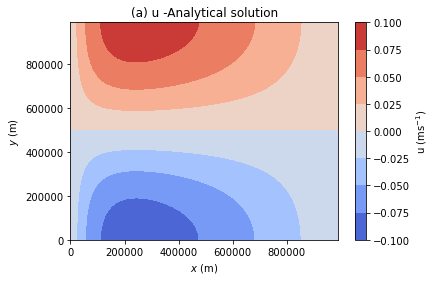

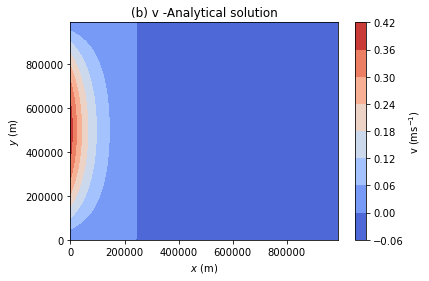

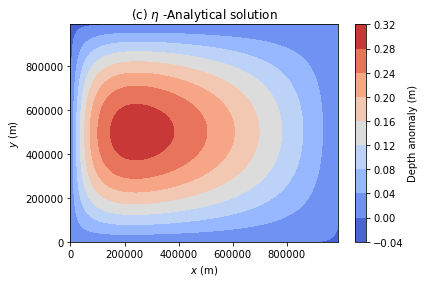

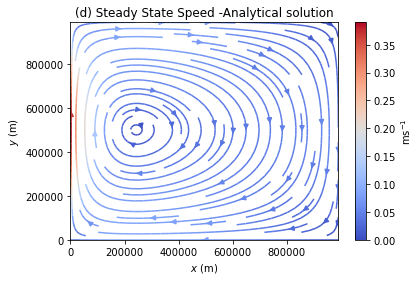

In [6]:
dx = 10**4
dy = 10**4
eta_0 = -0.11258543674198031 # Found from task below
X, Y, u_st, v_st, eta_st = steady_state_sol(dx, dy, eta_0)


fig1 = plt.figure(1)
plt1 = plt.contourf(X, Y, u_st, cmap=cm.coolwarm)
cbar1 = fig1.colorbar(plt1, label='u (ms$^{-1}$)')
plt.title('(a) u -Analytical solution')
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")

fig2 = plt.figure(2)
plt2 = plt.contourf(X, Y, v_st, cmap=cm.coolwarm)
cbar2 = fig2.colorbar(plt2, label='v (ms$^{-1}$)')
plt.title('(b) v -Analytical solution')
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")

fig3 = plt.figure(3)
plt3 = plt.contourf(X, Y, eta_st, cmap=cm.coolwarm)
cbar3 = fig3.colorbar(plt3, label='Depth anomaly (m)')
plt.title('(c) $\eta$ -Analytical solution')
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")

fig4 = plt.figure(4)
color = np.hypot(u_st, v_st)
plt4 = plt.streamplot(X, Y, u_st, v_st, color=color, cmap=cm.coolwarm)
cbar4 = fig4.colorbar(plt4.lines,label='ms$^{-1}$')
plt.title('(d) Steady State Speed -Analytical solution')
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")

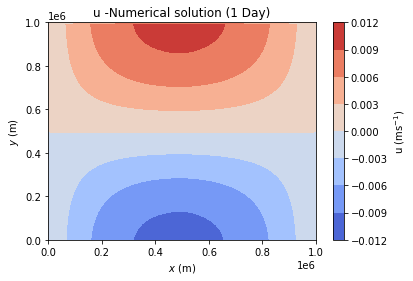

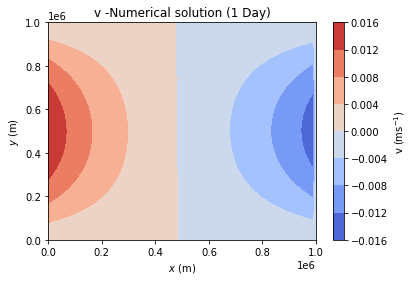

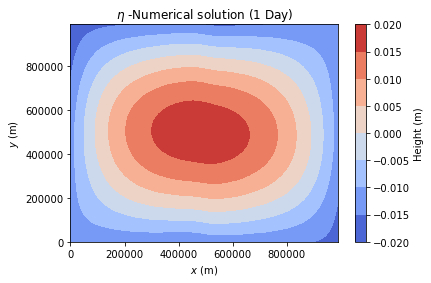

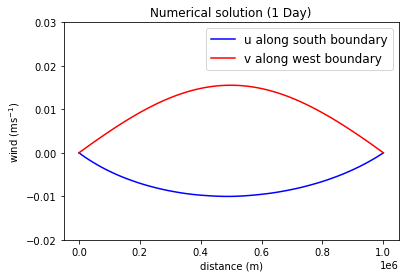

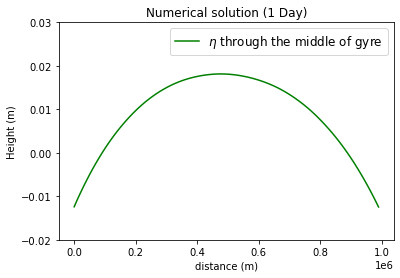

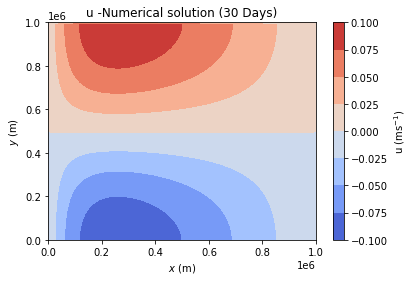

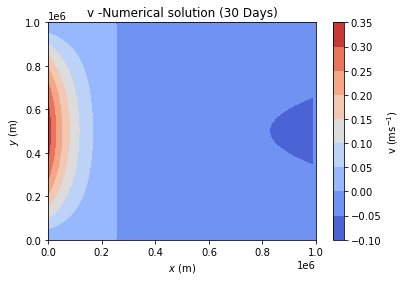

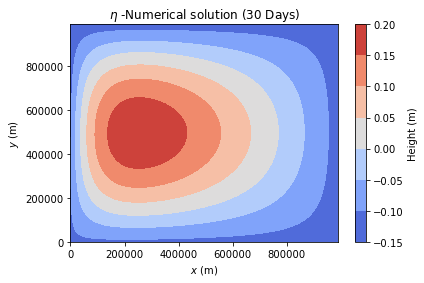

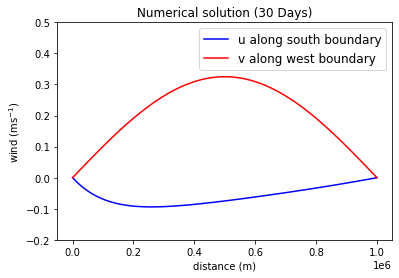

In [7]:
# STEP 1: 
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(86400/dt)

u, v, eta, energy = run_model(dx, dy, dt, nt, output_energy=True)
x, y, x_plus_one, y_plus_one = Arakawa_C_grid(dx, dy, consts, 'plot')
plot_Task_D1(dy, x, y, x_plus_one, y_plus_one, u, v, eta, \
               plt_id = 0, y_lim = [-0.02,0.03], legend_loc = 'upper right')
    
# STEP 2: 
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(30*86400/dt)   

u, v, eta, energy = run_model(dx, dy, dt, nt, output_energy=True)
x, y, x_plus_one, y_plus_one = Arakawa_C_grid(dx, dy, consts, 'plot')
plot_Task_D30(dy, x, y, x_plus_one, y_plus_one, u, v, eta, \
               plt_id = 5, y_lim = [-0.2,0.5], legend_loc = 'upper right')
    
# STEP 3:
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(30*86400/dt)   

u, v, eta, energy = run_model(dx, dy, dt, nt, output_energy=True)
x, y, x_plus_one, y_plus_one = Arakawa_C_grid(dx, dy, consts, 'plot')    
eta_0 = -0.11258543674198031 # Found from task below
_, _, u_st, v_st, eta_st = steady_state_sol(dx, dy, eta_0)
u_st = np.pad(u_st, pad_width=((0,0),(0,1)))
v_st = np.pad(v_st, pad_width=((0,1),(0,0)))
u_diff = u - u_st
v_diff = v - v_st
eta_diff = eta - eta_st

plot_Task_Ddiff(dy, x, y, x_plus_one, y_plus_one, u_diff, v_diff, eta_diff, \
               plt_id = 10, legend_loc = 'upper right')

-0.11258543674198031


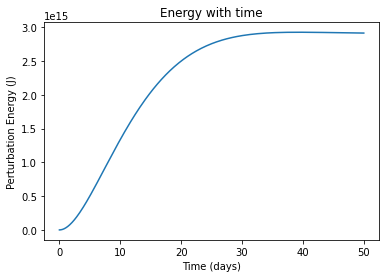

In [8]:
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(50*86400/dt)   

x, y, x_plus_one, y_plus_one = Arakawa_C_grid(dx, dy, consts, 'plot')
u, v, eta, energy = run_model(dx, dy, dt, nt, output_energy=True)

plot_energy(20, energy, dt, nt, dx)
    
# halve the grid-spacing of your model
dx = 5000  #m
dy = 5000   #m
dt = 30    #s
nt = int(50*86400/dt)  

x, y, x_plus_one, y_plus_one = Arakawa_C_grid(dx, dy, consts, 'plot')
u, v, eta, energy = run_model(dx, dy, dt, nt, output_energy=True)

plot_energy(25, energy, dt, nt, dx)

eta_0 = -0.11258543674198031 # Found from task below
_, _, u_st, v_st, eta_st = steady_state_sol(dx, dy, eta_0)
u_st = np.pad(u_st, pad_width=((0,0),(0,1)))
v_st = np.pad(v_st, pad_width=((0,1),(0,0)))
u_diff = u - u_st
v_diff = v - v_st
eta_diff = eta - eta_st

#energy_diff = Perturbation_energy(u_diff, v_diff, eta_diff, dx, dy)
#print('enery from difference field = ', energy_diff)

eta_0 = eta[100,0]
print(eta_0)

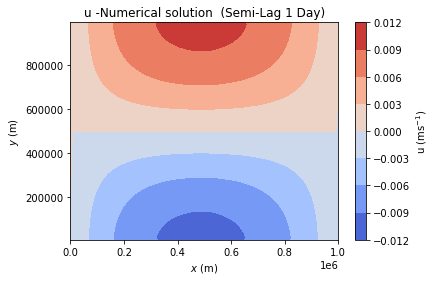

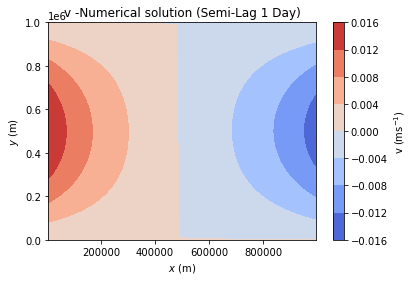

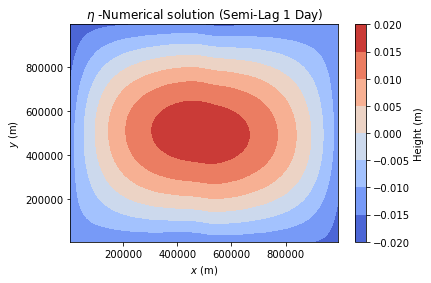

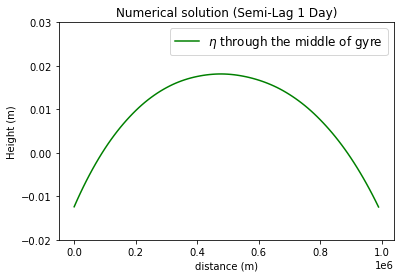

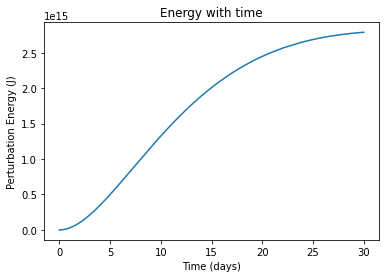

In [9]:
dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(86400/dt)

eta_0 = -0.11258543674198031 # Found from task below
_, _, u_st, v_st, eta_st = steady_state_sol(dx, dy, eta_0)

#Task F Semi Lagrangian
u, v, eta, energy = semi_lagrangian(dx, dy, dt, nt)
plot_TaskF1(0, u, v, eta, dx , dy, dt, nt, \
           y_lim = [-0.02,0.03], legend_loc = 'upper right')

dx = 10**4   #m
dy = 10**4   #m
dt = 70      #s
nt = int(30*86400/dt)

eta_0 = -0.11258543674198031 # Found from task below
_, _, u_st, v_st, eta_st = steady_state_sol(dx, dy, eta_0)

#Task F Semi Lagrangian
u, v, eta, energy = semi_lagrangian(dx, dy, dt, nt)
plot_TaskF30(5, u, v, eta, dx , dy, dt, nt, \
           y_lim = [-0.2,0.5], legend_loc = 'upper right')

plot_energy(20, energy, dt, nt, dx)